# Brain-Computer Interface data classification

In [519]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

In [520]:
sys.path.append('/Users/gencgeci/Downloads/eeg')  #Path to data_loader code, cloned from github

In [521]:
data_loader = DataBuildClassifier('/Users/gencgeci/Downloads/eeg') #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
all_subjects = [25, 26,27,28,29,30,32,33,34,35,36,37,38]
subjects = data_loader.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),resample_to=500)
#print(subjects.keys())
X,y = subjects[25]
print(X.shape) #EEG epochs (Trials) x Time x Channels
print(y.shape)

(329, 150, 19)
(329,)


# Data Pre-Processing

We will prepare the data to feed into our upcoming algorithm. We will need to first change the shape of data. That is, we will have EEG epochs as (Trials) x Channels x Time instead. We also add another dimensionality to turn the data into four dimensions so that it adapts the architecture we selected from the paper.

- <b> Training data: </b> comprises of 80% of all the data.
- <b> Validation data: </b> comprises of 10% of all the data.
- <b> Testing data: </b> comprises of 10% of all the data.

In [522]:
def prepare_data(X, y, channels, sample):

    kernels, chans, samples = 1, channels, sample

    tenX = tf.convert_to_tensor(X)
    tenX = tf.reshape(tenX, shape = (len(X), chans, samples))
    X = tenX.numpy()

    X_train      = X[0:int(np.round(len(X)*.8)),]
    Y_train      = y[0:int(np.round(len(X)*.8))]
    X_validate   = X[int(np.round(len(X)*.8)):int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2)),]
    Y_validate   = y[int(np.round(len(X)*.8)):int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2))]
    X_test       = X[int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2)):,]
    Y_test       = y[int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2)):]

    X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
    X_validate = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
    X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

    Y_train = np_utils.to_categorical(Y_train-1)
    coord_1_train, coord_2_train = [Y_train[i][0] for i in range(len(Y_train))], [Y_train[i][Y_train.shape[1]-1] for i in range(len(Y_train))]
    Y_train = np.array([[coord_1_train[i], coord_2_train[i]] for i in range(len(coord_1_train))])

    Y_validate = np_utils.to_categorical(Y_validate-1)
    coord_1_val, coord_2_val = [Y_validate[i][0] for i in range(len(Y_validate))], [Y_validate[i][Y_validate.shape[1]-1] for i in range(len(Y_validate))]
    Y_validate = np.array([[coord_1_val[i], coord_2_val[i]] for i in range(len(coord_1_val))])

    Y_test = np_utils.to_categorical(Y_test-1)
    coord_1_test, coord_2_test = [Y_test[i][0] for i in range(len(Y_test))], [Y_test[i][Y_test.shape[1]-1] for i in range(len(Y_test))]
    Y_test = np.array([[coord_1_test[i], coord_2_test[i]] for i in range(len(coord_1_test))])
    
    
    return X_train, Y_train, X_validate, Y_validate, X_test, Y_test

In [523]:
X_train, Y_train, X_validate, Y_validate, X_test, Y_test = prepare_data(X, y, X.shape[2], X.shape[1])[0],  prepare_data(X, y, X.shape[2], X.shape[1])[1],prepare_data(X, y, X.shape[2], X.shape[1])[2],prepare_data(X, y, X.shape[2], X.shape[1])[3], prepare_data(X, y, X.shape[2], X.shape[1])[4], prepare_data(X, y, X.shape[2], X.shape[1])[5]

### Data Pre-Processing 'Hyperparameters'

Classification algorithms can suffer from overfitting. Below we define a function which assigns weights to the classes if the data is overbalanced. That is, if one of the classes (say 'big_class') makes up over 60% of the data in the combination of training and validation sets, then we assign the class a weight equal to: **log(2*(big_class/(1-big_class)))**. 

We expect this method to make our algorithm less biased. The metric of weighing has been chosen through trial and error.

In [524]:
def hyper_params(Y_train, Y_validate):
    i = 0
    k1 = len([i+1 for i in range(len(Y_train) + len(Y_validate)) if y[i]==1])/(len(Y_train) + len(Y_validate))
    
    if k1 > 0.6:
        k1, k2 = 1, np.log(2*(k1/(1-k1)))
    elif k1 < 0.4:
        k1, k2 = np.log(2*((1-k1)/k1)), 1
    else:
        k1, k2 
        
    return k1, k2

In [525]:
class_weights = {0:hyper_params(Y_train, Y_validate)[0], 1:hyper_params(Y_train, Y_validate)[1]}

# Model Selection

On the model...

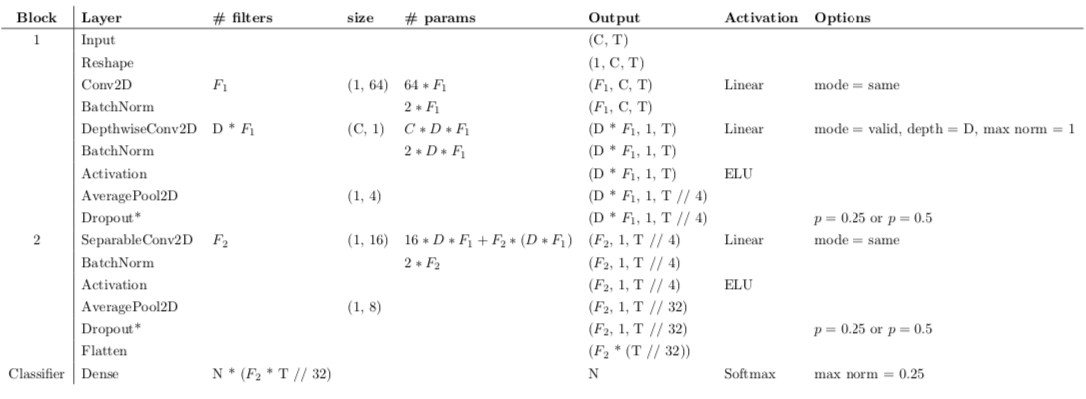

In [123]:
from IPython.display import Image
Image("params.png")

In [526]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D, depthwise_constraint = max_norm(1.), padding = 'same')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), padding = 'same')(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [527]:
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

In [528]:
model.fit(X_train, np.array(Y_train), batch_size = 16, epochs = 300, validation_data=(X_validate, np.array(Y_validate)), class_weight = class_weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 263 samples, validate on 33 samples
Epoch 1/300
263/263 [==============================] - 2s 6ms/sample - loss: 0.7539 - accuracy: 0.6312 - val_loss: nan - val_accuracy: 0.4848
Epoch 2/300
263/263 [==============================] - 0s 976us/sample - loss: 0.6608 - accuracy: 0.8517 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/300
263/263 [==============================] - 0s 808us/sample - loss: 0.6337 - accuracy: 0.8517 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/300
263/263 [==============================] - 0s 1ms/sample - loss: 0.6120 - accuracy: 0.8745 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/300
263/263 [==============================] - 0s 1ms/sample - loss: 0.5514 - accuracy: 0.8935 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/300
263/263 [==============================] - 0s 1ms/sample - loss: 0.5742 - accuracy: 0.8935 - val_loss: nan - val_accuracy: 0.4848
Epoch 7/300
263/263 [============

263/263 [==============================] - 0s 772us/sample - loss: 0.4003 - accuracy: 0.9049 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 55/300
263/263 [==============================] - 0s 776us/sample - loss: 0.3815 - accuracy: 0.9240 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 56/300
263/263 [==============================] - 0s 775us/sample - loss: 0.3436 - accuracy: 0.9163 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 57/300
263/263 [==============================] - 0s 787us/sample - loss: 0.3976 - accuracy: 0.8973 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 58/300
263/263 [==============================] - 0s 774us/sample - loss: 0.3842 - accuracy: 0.9087 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 59/300
263/263 [==============================] - 0s 791us/sample - loss: 0.3859 - accuracy: 0.8935 - val_loss: nan - val_accuracy: 0.4848
Epoch 60/300
263/263 [==============================] - 0s 784us/sample - loss: 0.4456 - accuracy: 0.8897 - val_loss: nan -

Epoch 109/300
263/263 [==============================] - 0s 813us/sample - loss: 0.1918 - accuracy: 0.9658 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 110/300
263/263 [==============================] - 0s 790us/sample - loss: 0.1789 - accuracy: 0.9620 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 111/300
263/263 [==============================] - 0s 781us/sample - loss: 0.1798 - accuracy: 0.9772 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 112/300
263/263 [==============================] - 0s 778us/sample - loss: 0.1998 - accuracy: 0.9544 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 113/300
263/263 [==============================] - 0s 763us/sample - loss: 0.1617 - accuracy: 0.9772 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 114/300
263/263 [==============================] - 0s 775us/sample - loss: 0.1597 - accuracy: 0.9658 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 115/300
263/263 [==============================] - 0s 769us/sample - loss: 0.1969 - accuracy: 

263/263 [==============================] - 0s 806us/sample - loss: 0.0866 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.0303
Epoch 164/300
263/263 [==============================] - 0s 1ms/sample - loss: 0.0845 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.0303
Epoch 165/300
263/263 [==============================] - 0s 980us/sample - loss: 0.0876 - accuracy: 0.9886 - val_loss: nan - val_accuracy: 0.0303
Epoch 166/300
263/263 [==============================] - 0s 832us/sample - loss: 0.0813 - accuracy: 0.9886 - val_loss: 19697414967179715018752.0000 - val_accuracy: 0.0000e+00
Epoch 167/300
263/263 [==============================] - 0s 832us/sample - loss: 0.0773 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.4848
Epoch 168/300
263/263 [==============================] - 0s 780us/sample - loss: 0.0791 - accuracy: 0.9962 - val_loss: 41594580853903491072.0000 - val_accuracy: 0.5152
Epoch 169/300
263/263 [==============================] - 0s 772us/sample - loss: 0.1052 -

263/263 [==============================] - 0s 779us/sample - loss: 0.0829 - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 218/300
263/263 [==============================] - 0s 813us/sample - loss: 0.0738 - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 219/300
263/263 [==============================] - 0s 779us/sample - loss: 0.0921 - accuracy: 0.9772 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 220/300
263/263 [==============================] - 0s 833us/sample - loss: 0.0586 - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 221/300
263/263 [==============================] - 0s 878us/sample - loss: 0.0545 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.5152
Epoch 222/300
263/263 [==============================] - 0s 789us/sample - loss: 0.0535 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 223/300
263/263 [==============================] - 0s 814us/sample - loss: 0.0566 - accuracy: 0.9924 - val_loss:

263/263 [==============================] - 0s 747us/sample - loss: 0.0459 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.0303
Epoch 273/300
263/263 [==============================] - 0s 783us/sample - loss: 0.0528 - accuracy: 0.9962 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 274/300
263/263 [==============================] - 0s 754us/sample - loss: 0.0595 - accuracy: 0.9848 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 275/300
263/263 [==============================] - 0s 770us/sample - loss: 0.0767 - accuracy: 0.9810 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 276/300
263/263 [==============================] - 0s 785us/sample - loss: 0.0708 - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 277/300
263/263 [==============================] - 0s 808us/sample - loss: 0.0633 - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 278/300
263/263 [==============================] - 0s 787us/sample - loss: 0.1636 - accuracy: 0.9620 - val_loss:

In [517]:
model.predict(X_test)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [496]:
int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2))

296

In [499]:
X[int(np.round(len(X)*.8)):int(np.round(len(X)*.8)) + int(np.round((len(X) - int(np.round(len(X)*.8)))/2)),]

array([[[-1.32636395e+01, -1.26079002e+01, -1.13577858e+01, ...,
         -2.33070114e+00, -2.52054945e+00, -1.41830602e+00],
        [-1.45321879e+01, -1.32454518e+01, -1.24723899e+01, ...,
         -2.90477262e+00, -3.17849817e+00, -1.98454483e+00],
        [-1.54123886e+01, -1.36522456e+01, -1.32261002e+01, ...,
         -2.99572437e+00, -3.38918265e+00, -1.86243607e+00],
        ...,
        [-1.48089997e+01, -1.16365604e+01, -1.89379718e+01, ...,
         -5.50037458e+00, -3.58826934e+00, -7.54389161e+00],
        [-1.59188677e+01, -1.30728588e+01, -1.93837741e+01, ...,
         -5.70609024e+00, -3.64098203e+00, -7.62318759e+00],
        [-1.70691281e+01, -1.45173551e+01, -1.98305808e+01, ...,
         -5.89897838e+00, -3.92532502e+00, -7.56005065e+00]],

       [[ 2.64481887e+00,  3.19674026e+00,  6.92154806e-04, ...,
          3.30196125e+00,  6.06486724e+00,  3.75472464e+00],
        [ 2.23001616e+00,  2.58333286e+00,  1.97510051e-01, ...,
          3.05584435e+00,  5.88014030e

In [518]:
np.log(3)

1.0986122886681098